<a href="https://colab.research.google.com/github/shlee0619/Project_Disease/blob/main/0211%EC%BD%94%EB%A1%9C%EB%82%98(%EC%B5%9C%EC%A2%85%EB%B3%B8_%EC%B4%88%EC%95%88)4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
########################################
# 0. 환경 설정 & 라이브러리 설치
########################################
# Colab에서 Google Drive 연동
from google.colab import drive
drive.mount('/content/gdrive')

# 필요한 라이브러리 설치
!pip install optuna keras-tuner statsmodels prophet tensorflow==2.12.0 tensorflow-addons==0.23.0 keras-tcn xgboost

########################################
# 1. 라이브러리 import
########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prophet
from prophet import Prophet

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (InputLayer, Dense, Dropout, LSTM,
                                     SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten)

# TCN
from tcn import TCN

# XGBoost
from xgboost import XGBRegressor

# 기타
import optuna

# 한글 폰트 설정 (Colab)
!apt-get update -qq
!apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 임포트 및 한글 폰트 설정 완료!")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
라이브러리 임포트 및 한글 폰트 설정 완료!


In [2]:
def load_data(data_path):
    """
    CSV 파일을 여러 인코딩 방식으로 시도하여 불러옵니다.
    """
    try:
        try:
            df_ = pd.read_csv(data_path, encoding='cp949')
        except UnicodeDecodeError:
            try:
                df_ = pd.read_csv(data_path, encoding='latin-1')
            except UnicodeDecodeError:
                df_ = pd.read_csv(data_path, encoding='cp1252')
        print("[INFO] 데이터 불러오기 성공!")
        return df_
    except FileNotFoundError:
        print(f"[ERROR] 파일을 찾을 수 없습니다. 경로: {data_path}")
    except Exception as e:
        print("[ERROR] 예기치 못한 에러 발생:", e)

# 데이터 로드
DATA_PATH = '/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled_Plus_Traffic.csv'
df = load_data(DATA_PATH)

[INFO] 데이터 불러오기 성공!


In [3]:
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균일강수량(mm)','평균풍속(m/s)','평균습도(%rh)','일조합(hr)','일사합(MJ/m2)','Traffic']

df['Cases_Diff'] = df['Cases'].diff(1)

# Date 컬럼이 존재한다고 가정
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values('Date').dropna(subset=['Date']).reset_index(drop=True)

print("\n데이터 예시(상위 5행):")
print(df.head())
print("\n데이터 info:")
print(df.info())
print("\n데이터 통계치:")
print(df.describe())


데이터 예시(상위 5행):
        Date  Cases       SO2        CO        O3       NO2       PM10  \
0 2020-02-01      0  0.003274  0.699089  0.026038  0.022698  63.185218   
1 2020-02-02      0  0.003502  0.748826  0.028493  0.020737  69.092334   
2 2020-02-03      0  0.003140  0.463362  0.029590  0.015894  32.560316   
3 2020-02-04      3  0.003329  0.465114  0.023674  0.019638  29.410079   
4 2020-02-05      3  0.003002  0.374520  0.029291  0.011450  22.960480   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  최다일강수량(mm)  평균풍속(m/s)  최대풍속(m/s)  \
0  47.416719      2.2        7.8  ...         0.2        1.5       12.5   
1  52.897434      2.1        7.8  ...         0.7        1.3        9.5   
2  21.600817      1.3        5.7  ...         0.7        2.3       13.1   
3  18.842018      0.1        6.3  ...         2.0        1.8       13.4   
4  11.594881     -3.6        1.0  ...        26.0        3.0       14.7   

   최대순간풍속(m/s)  평균습도(%rh)  최저습도(%rh)  일조합(hr)  일사합(MJ/m2)  Traffic  Cases_Diff  
0      

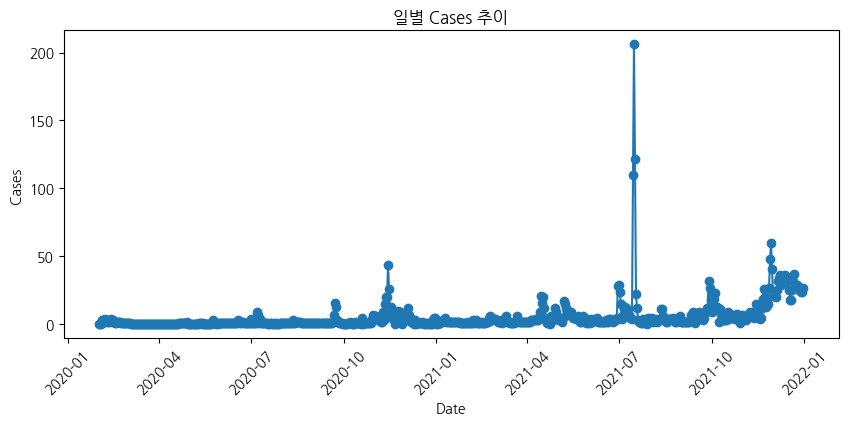

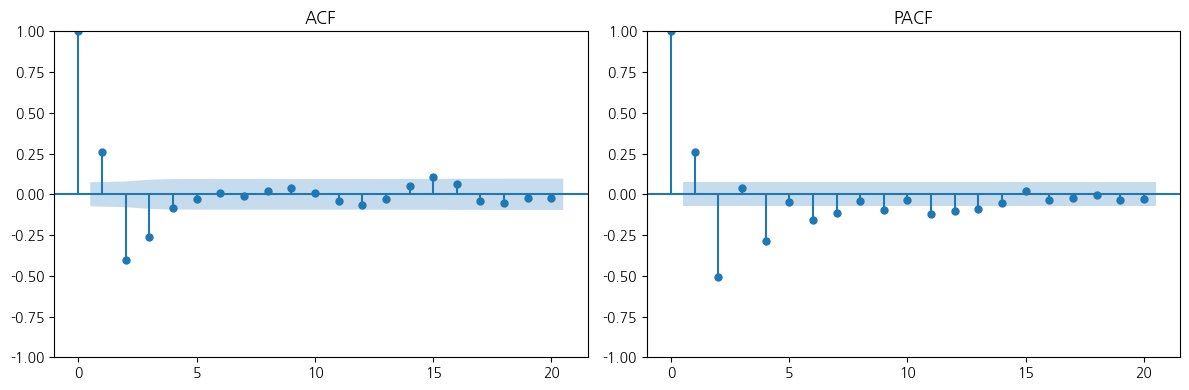

In [4]:
########################################
# 3. 간단 EDA (시각화)
########################################
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Cases'], marker='o')
plt.title("일별 Cases 추이")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.show()

# ACF/PACF 살펴보기
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca())
plt.title("ACF")
plt.subplot(1,2,2)
plot_pacf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca(), method='ywm')
plt.title("PACF")
plt.tight_layout()
plt.show()

In [5]:
def create_lag_features(dataframe, col_targets, lags):
    """
    시계열 데이터에 대해 원하는 시차(lags) 만큼의 컬럼 생성.
    예: lags=(1,7,14)이면 col_target_lag1, col_target_lag7, col_target_lag14 추가
    """
    df_ = dataframe.copy()
    for col_target in col_targets:  # Iterate through each column in col_targets
        for lag in lags:
            df_[f"{col_target}_lag{lag}"] = df_[col_target].shift(lag)
    df_.dropna(inplace=True)
    return df_

df = create_lag_features(df, ['O3', 'PM25', '평균기온(℃)', '평균습도(%rh)','평균풍속(m/s)','Cases'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14])

In [6]:
feature_cols = ['SO2','CO','O3','NO2','O3_lag10','평균기온(℃)_lag10', 'PM25_lag13','평균풍속(m/s)_lag13','Traffic', 'Cases_lag1']  #SARIMAX에서는 이게 best였음.


In [7]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(533, 108), Test=(153, 108)
최종 학습세트 크기: (533, 10) 테스트세트 크기: (153, 10)


In [8]:
########################################
# 6. 데이터 스케일링 (필요시) - Feature만 스케일링, y는 스케일링 하지 않음
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y는 스케일링하지 않음
y_train_scaled = y_train.values # 스케일링 제거
y_test_scaled = y_test.values   # 스케일링 제거

In [9]:
########################################
# 7. 모델 성능 평가 함수 (MAE, RMSE, MAPE)
########################################
def evaluate_performance(y_true, y_pred, model_name="Model"):
    """
    MAE, RMSE, MAPE 세 가지 지표를 계산하여 dict로 반환
    """
    mae_value = mean_absolute_error(y_true, y_pred)
    rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
    # y_true가 0인 케이스 대비를 위해 아주 작은 값 더해주는 것도 방법
    mape_value = mean_absolute_percentage_error(y_true, y_pred)

    print(f"[{model_name}] MAE={mae_value:.3f}, RMSE={rmse_value:.3f}, MAPE={mape_value:.3f}") # MAPE 소수점 3자리로 변경
    return {
        'model': model_name,
        'MAE': mae_value,
        'RMSE': rmse_value,
        'MAPE': mape_value
    }

In [10]:
########################################
# 8-1. SARIMAX (ARIMAX) 예시
########################################
def train_sarimax(train_data, test_data, exog_cols, order=(1,0,1), seasonal_order=(0,0,1,7)):
    """
    SARIMAX(ARIMAX) 모델을 학습하고 예측값을 반환.
    order, seasonal_order는 필요에 따라 조정.
    """
    # train
    y_train_sar = train_data['Cases']
    X_train_sar = train_data[exog_cols]

    # test
    y_test_sar  = test_data['Cases']
    X_test_sar  = test_data[exog_cols]

    model = sm.tsa.statespace.SARIMAX(
        endog=y_train_sar,
        exog=X_train_sar,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    print("SARIMAX 학습 완료! summary:\n", result.summary())

    # 예측
    n_test = len(y_test_sar)
    forecast = result.predict(
        start=len(y_train_sar),
        end=len(y_train_sar)+n_test-1,
        exog=X_test_sar
    )
    return forecast


sarimax_pred = train_sarimax(train_df, test_df, exog_cols=feature_cols)
sarimax_result = evaluate_performance(y_test, sarimax_pred, model_name="SARIMAX")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMAX 학습 완료! summary:
                                      SARIMAX Results                                     
Dep. Variable:                             Cases   No. Observations:                  533
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood               -1747.505
Date:                           Tue, 11 Feb 2025   AIC                           3523.009
Time:                                   01:55:41   BIC                           3582.670
Sample:                                        0   HQIC                          3546.373
                                           - 533                                         
Covariance Type:                             opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
SO2               653.5682   6.49e-06   1.01e+08      0.000     653.568     653.568
CO 

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
import itertools
# 1. 모델 성능 평가 함수 (MAE, RMSE, MAPE) - 이미 정의되어 있음

# 2. SARIMAX (ARIMAX) 모델 학습 및 예측 함수 - 이미 정의되어 있음

# 3. lag 후보 리스트 설정 (9, 10, 11, 12, 13)
lag_candidates = [9, 10, 11, 12, 13]

# 결과를 저장할 리스트
results_list = []

# 4. 모든 625개 lag 조합에 대해 반복 (순서는: O3, 평균기온(℃), PM25, 평균풍속(m/s))
for lag_comb in itertools.product(lag_candidates, repeat=4):
    lag_O3, lag_temp, lag_PM25, lag_wind = lag_comb

    # 동적으로 feature_cols 리스트 생성
    feature_cols_sarimax_tuning = [  # 변수명 변경 (feature_cols -> feature_cols_sarimax_tuning)
        'SO2', 'CO', 'O3', 'NO2',
        f'O3_lag{lag_O3}',
        f'평균기온(℃)_lag{lag_temp}',
        f'PM25_lag{lag_PM25}',
        f'평균풍속(m/s)_lag{lag_wind}',
        'Traffic', 'Cases_lag1'
    ]

    print(f"\n처리 중인 lag 조합: O3_lag{lag_O3}, 평균기온(℃)_lag{lag_temp}, PM25_lag{lag_PM25}, 평균풍속(m/s)_lag{lag_wind}")

    try:
        # 5. Train/Test 데이터 분리 (날짜 기준)
        split_date = pd.to_datetime('2021-07-31')
        train_df_sarimax_tune = df[df['Date'] <= split_date].copy() # 변수명 변경
        test_df_sarimax_tune  = df[df['Date'] > split_date].copy()  # 변수명 변경

        # feature_cols에 해당하는 데이터 추출
        X_train_sarimax_tune = train_df_sarimax_tune[feature_cols_sarimax_tuning] # 변수명 변경
        y_train_sarimax_tune = train_df_sarimax_tune['Cases'] # 변수명 변경
        X_test_sarimax_tune  = test_df_sarimax_tune[feature_cols_sarimax_tuning]  # 변수명 변경
        y_test_sarimax_tune  = test_df_sarimax_tune['Cases']  # 변수명 변경

        # Shift로 인해 생긴 결측치 제거
        X_train_sarimax_tune = X_train_sarimax_tune.dropna() # 변수명 변경
        y_train_sarimax_tune = y_train_sarimax_tune.loc[X_train_sarimax_tune.index] # 변수명 변경
        X_test_sarimax_tune  = X_test_sarimax_tune.dropna() # 변수명 변경
        y_test_sarimax_tune  = y_test_sarimax_tune.loc[X_test_sarimax_tune.index] # 변수명 변경

        # train_df와 test_df도 feature_cols가 있는 행만 남도록 업데이트
        train_df_sarimax_tune = train_df_sarimax_tune.loc[X_train_sarimax_tune.index] # 변수명 변경
        test_df_sarimax_tune  = test_df_sarimax_tune.loc[X_test_sarimax_tune.index]  # 변수명 변경

        # 6. SARIMAX 모델 학습 및 예측 수행
        sarimax_pred = train_sarimax(train_df_sarimax_tune, test_df_sarimax_tune, exog_cols=feature_cols_sarimax_tuning) # 변수명 변경

        # 7. Test 데이터셋에 대한 성능 평가 (여기서는 MAPE 사용)
        performance = evaluate_performance(y_test_sarimax_tune, sarimax_pred, model_name=f"SARIMAX_{lag_comb}") # 변수명 변경

        # 결과 저장
        results_list.append({
            'lag_combination': lag_comb,
            'MAPE': performance['MAPE']
        })
    except Exception as e:
        print(f"에러 발생: {e} (lag 조합: {lag_comb})")
        continue

NameError: name 'itertools' is not defined

In [ ]:
# 8. 모든 조합 중 MAPE가 최소인 최적의 lag 조합 선택 및 출력
if results_list:
    best_result = min(results_list, key=lambda x: x['MAPE'])
    print("\n최적의 lag 조합:", best_result['lag_combination'])
    print("최소 MAPE 값:", best_result['MAPE'])
else:
    print("유효한 결과가 없습니다.")

In [12]:
########################################
# 8-2. LSTM
#  => 시퀀스 형식으로 데이터 변환 필요
########################################
def make_sequence_data(X, y, window=7):
    """
    RNN 계열(LSTM, GRU, CNN-1D 등)을 위해
    window 크기만큼 과거 데이터를 묶어서 (samples, window, features) 형태 반환
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

# 훈련/테스트를 window 시퀀스로 변환
window_size = 7
X_train_seq, y_train_seq = make_sequence_data(X_train_scaled, y_train_scaled, window=window_size)
X_test_seq,  y_test_seq  = make_sequence_data(X_test_scaled, y_test_scaled, window=window_size)

print("LSTM용 시퀀스 데이터 크기:", X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape)

LSTM용 시퀀스 데이터 크기: (526, 7, 10) (526,) (146, 7, 10) (146,)


In [13]:
def objective_lstm(trial):
    """
    Optuna를 사용하여 LSTM 모델의 하이퍼파라미터를 조정하는 objective 함수.
    목표: validation loss 최소화
    하이퍼파라미터:
      - lstm_units: LSTM 은닉 유닛 수 (32~256, step=32)
      - dropout_rate: 드롭아웃 비율 (0.1 ~ 0.5, step=0.1)
      - learning_rate: Adam 옵티마이저의 학습률 (1e-4 ~ 1e-2, log scale)
      - batch_size: 배치 사이즈 (16, 32, 64)
    """
    # 하이퍼파라미터 샘플링
    lstm_units = trial.suggest_int("lstm_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 20  # 튜닝 목적 상 적은 에포크 사용

    # 모델 구성
    model = Sequential()
    model.add(LSTM(lstm_units,
                   activation='tanh',
                   input_shape=(window_size, X_train_seq.shape[2]),
                   return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # 회귀 출력
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())

    # EarlyStopping 콜백: validation loss 개선 없으면 중단 (patience=3)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=3,
                                               restore_best_weights=True)

    # 모델 학습 (validation_split 사용)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )

    # 가장 낮은 validation loss를 objective 값으로 반환
    val_loss = min(history.history['val_loss'])
    return val_loss

# Optuna 스터디 생성 및 최적화 실행
study_lstm = optuna.create_study(direction='minimize') # 변수명 study -> study_lstm 변경
study_lstm.optimize(objective_lstm, n_trials=30)

# 최적의 trial 결과 출력
print("최적의 LSTM trial:")
print("Validation Loss:", study_lstm.best_trial.value)
print("최적의 하이퍼파라미터:", study_lstm.best_trial.params)

[I 2025-02-11 01:56:04,747] A new study created in memory with name: no-name-b03ca344-da2e-418f-9a6b-2918a01e1a77
<ipython-input-13-4b87f64886b9>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-11 01:56:22,447] Trial 0 finished with value: 115495.875 and parameters: {'lstm_units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.0065150306785139896, 'batch_size': 64}. Best is trial 0 with value: 115495.875.
[I 2025-02-11 01:56:28,141] Trial 1 finished with value: 41491.9921875 and parameters: {'lstm_units': 96, 'dropout_rate': 0.1, 'learning_rate': 0.0021795580432188884, 'batch_size': 32}. Best is trial 1 with value: 41491.9921875.
[I 2025-02-11 01:56:32,036] Trial 2 finished with value: 320562.34375 and parameters: {'lstm_units': 160, 'dropout_rate'

최적의 LSTM trial:
Validation Loss: 12524.013671875
최적의 하이퍼파라미터: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0014356404299452747, 'batch_size': 32}


In [14]:
def build_lstm_model(input_shape, lstm_units, dropout_rate, learning_rate):
    """
    최적의 하이퍼파라미터를 반영한 간단한 LSTM 모델 구성 예시

    매개변수:
      - input_shape: 입력 데이터의 shape (timesteps, features)
      - lstm_units: LSTM 층의 유닛 수 (예: 64)
      - dropout_rate: Dropout 비율 (예: 0.4)
      - learning_rate: Adam 옵티마이저 학습률 (예: 0.0016895578489875814)
    """
    model_ = Sequential()
    model_.add(LSTM(lstm_units, activation='tanh', input_shape=input_shape, return_sequences=False))
    model_.add(Dropout(dropout_rate))
    model_.add(Dense(1))  # 회귀 출력
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model_.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model_

In [15]:
best_params_lstm = study_lstm.best_trial.params # 변수명 best_params -> best_params_lstm 변경
# 최적 하이퍼파라미터를 반영하여 모델 생성
lstm_units_best = best_params_lstm['lstm_units']
dropout_rate_best = best_params_lstm['dropout_rate']
learning_rate_best = best_params_lstm['learning_rate']
batch_size_best = best_params_lstm['batch_size']
epochs_best = 20

lstm_model = build_lstm_model(
    input_shape=(window_size, X_train_seq.shape[2]),
    lstm_units=lstm_units_best,
    dropout_rate=dropout_rate_best,
    learning_rate=learning_rate_best
)

# 모델 학습
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=epochs_best,
    batch_size=batch_size_best,
    verbose=0 # verbose=0으로 변경 (학습 과정 출력 제거)
)


# 예측
lstm_pred_scaled = lstm_model.predict(X_test_seq).flatten()
# 역스케일링 - y는 이제 스케일링 안 했으므로 역스케일링 불필요. 예측값은 스케일링 된 feature로 학습되었으므로, 스케일링 된 범위에 있음.
lstm_pred = lstm_pred_scaled # 역스케일링 제거

# 테스트셋 실제값(역스케일링) - y_test_seq는 스케일링 안 됨. 역스케일링 불필요
y_test_seq_inversed = y_test_seq # 역스케일링 제거

lstm_result = evaluate_performance(y_test_seq_inversed, lstm_pred, model_name="LSTM")

5/5 [==============================] - 1s 3ms/step
[LSTM] MAE=12.614, RMSE=17.083, MAPE=1.001


In [16]:
def objective_gru(trial):
    """
    Optuna를 사용하여 GRU 모델의 하이퍼파라미터를 조정하는 objective 함수.
    목표: validation loss 최소화

    하이퍼파라미터:
      - gru_units: GRU 은닉 유닛 수 (32~256, step=32)
      - dropout_rate: 드롭아웃 비율 (0.1 ~ 0.5, step=0.1)
      - learning_rate: Adam 옵티마이저의 학습률 (1e-4 ~ 1e-2, log scale)
      - batch_size: 배치 사이즈 (16, 32, 64)
    """
    # 하이퍼파라미터 샘플링
    gru_units = trial.suggest_int("gru_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 20  # 튜닝 목적 상 적은 에포크 사용

    # 모델 구성: GRU 레이어 사용
    model = Sequential()
    model.add(GRU(gru_units,
                  activation='tanh',
                  input_shape=(window_size, X_train_seq.shape[2]),
                  return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # 회귀 출력
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())

    # EarlyStopping 콜백: validation loss 개선 없으면 중단 (patience=3)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=3,
                                               restore_best_weights=True)

    # 모델 학습 (validation_split 사용)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )

    # 가장 낮은 validation loss를 objective 값으로 반환
    val_loss = min(history.history['val_loss'])
    return val_loss

# GRU 모델에 대해 Optuna 스터디 생성 및 최적화 실행
study_gru = optuna.create_study(direction='minimize')
study_gru.optimize(objective_gru, n_trials=30)

# 최적의 trial 결과 출력
print("최적의 GRU trial:")
print("Validation Loss:", study_gru.best_trial.value)
print("최적의 하이퍼파라미터:", study_gru.best_trial.params)

[I 2025-02-11 01:59:29,687] A new study created in memory with name: no-name-18c6a752-9dda-44d6-a16d-bea3e789d661
<ipython-input-16-71de420f5d0d>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-11 01:59:37,372] Trial 0 finished with value: 147252.109375 and parameters: {'gru_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.001031572074407359, 'batch_size': 16}. Best is trial 0 with value: 147252.109375.
[I 2025-02-11 01:59:45,138] Trial 1 finished with value: 257586.484375 and parameters: {'gru_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0018576575155324823, 'batch_size': 32}. Best is trial 0 with value: 147252.109375.
[I 2025-02-11 01:59:50,284] Trial 2 finished with value: 365251.84375 and parameters: {'gru_units': 

최적의 GRU trial:
Validation Loss: 22785.560546875
최적의 하이퍼파라미터: {'gru_units': 96, 'dropout_rate': 0.2, 'learning_rate': 0.00998269179836755, 'batch_size': 32}


In [17]:
########################################
# 8-3. GRU
########################################
def build_gru_model(input_shape, gru_units, dropout_rate, learning_rate):
    """
    최적 하이퍼파라미터를 반영한 간단한 GRU 모델 구성 예시

    매개변수:
      - input_shape: 입력 데이터의 shape (timesteps, features)
      - gru_units: GRU 층의 유닛 수 (예: 192)
      - dropout_rate: Dropout 비율 (예: 0.5)
      - learning_rate: Adam 옵티마이저 학습률 (예: 0.00026388338318862067)
    """
    model_ = Sequential()
    model_.add(GRU(gru_units, activation='tanh', input_shape=input_shape, return_sequences=False))
    model_.add(Dropout(dropout_rate))
    model_.add(Dense(1))  # 회귀 출력
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model_.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model_

In [18]:
best_params_gru = study_gru.best_trial.params # 변수명 best_params -> best_params_gru 변경
# 최적 하이퍼파라미터를 반영하여 모델 생성

gru_units_best = best_params_gru['gru_units']
dropout_rate_best = best_params_gru['dropout_rate']
learning_rate_best = best_params_gru['learning_rate']
batch_size_best = best_params_gru['batch_size']
epochs_best = 20

# GRU 모델 생성 (최적 하이퍼파라미터 반영)
gru_model = build_gru_model(
    input_shape=(window_size, X_train_seq.shape[2]),
    gru_units=gru_units_best,
    dropout_rate=dropout_rate_best,
    learning_rate=learning_rate_best
)

# GRU 모델 학습
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=epochs_best,
    batch_size=batch_size_best,
    verbose=0 # verbose=0으로 변경 (학습 과정 출력 제거)
)

# 예측 및 역스케일링 - y는 이제 스케일링 안 했으므로 역스케일링 불필요
gru_pred_scaled = gru_model.predict(X_test_seq).flatten()
gru_pred = gru_pred_scaled # 역스케일링 제거

# 평가 함수로 성능 지표 계산 (MAE, RMSE, MAPE)
gru_result = evaluate_performance(y_test_seq_inversed, gru_pred, model_name="GRU")

5/5 [==============================] - 1s 4ms/step
[GRU] MAE=12.611, RMSE=17.083, MAPE=1.000


In [19]:
########################################
# 8-4. CNN (1D Convolution) - Optuna Hyperparameter Tuning
########################################
import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# ... (build_cnn_model function from previous code) ...
def build_cnn_model(input_shape, conv_filters=32, kernel_size=3, dropout_rate=0.2, optimizer='adam', learning_rate=0.001):
    """
    1D CNN 모델 빌드 함수 (하이퍼파라미터 튜닝 버전)
    Conv1D -> MaxPooling1D -> Flatten -> Dense(1)
    Loss function is MAPE
    """
    model_ = Sequential()
    model_.add(InputLayer(input_shape=input_shape))
    model_.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, padding='causal',
                      activation='relu')) # Removed input_shape from here
    model_.add(MaxPooling1D(pool_size=2))
    model_.add(Dropout(dropout_rate))
    model_.add(Flatten())
    model_.add(Dense(1))
    optimizer_ = tf.keras.optimizers.get(optimizer) # 문자열로 받은 optimizer 이름으로 옵티마이저 객체 생성
    if optimizer_.__class__.__name__ == 'Adam': # Adam optimizer인 경우 learning_rate 적용
        optimizer_ = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_.__class__.__name__ == 'RMSprop': # RMSprop optimizer인 경우 learning_rate 적용
        optimizer_ = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_.__class__.__name__ == 'SGD': # SGD optimizer인 경우 learning_rate 적용
        optimizer_ = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model_.compile(optimizer=optimizer_, loss=tf.keras.losses.MeanAbsolutePercentageError(), metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]) # Loss를 MAPE로 변경, metrics 유지
    return model_


def objective_cnn(trial): # objective -> objective_cnn 변수명 변경
    """Optuna objective function for CNN hyperparameter tuning - MAPE Loss 기준"""

    # (1) 하이퍼파라미터 제안 (Trial)
    conv_filters_ = trial.suggest_int('conv_filters', 16, 64, step=16)
    kernel_size_ = trial.suggest_int('kernel_size', 2, 5)
    dropout_rate_ = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    batch_size_ = trial.suggest_categorical('batch_size', [16, 32, 64])
    optimizer_ = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    learning_rate_ = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)


    # (2) CNN 모델 빌드 (최적화된 하이퍼파라미터 적용) - Loss 함수를 MAPE로 설정
    cnn_model_optuna = build_cnn_model(
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), # Correct input shape
        conv_filters=conv_filters_,
        kernel_size=kernel_size_,
        dropout_rate=dropout_rate_,
        optimizer=optimizer_,
        learning_rate=learning_rate_
    )

    # (3) 교차 검증 (TimeSeriesSplit, MAPE metric 사용)
    cv_mapes = []
    tscv_ = TimeSeriesSplit(n_splits=3) # TimeSeriesSplit 재정의 (objective 함수 안에서)

    for train_idx, val_idx in tscv_.split(X_train_seq): # TimeSeriesSplit instance 사용
        X_train_cv, X_val_cv = X_train_seq[train_idx], X_train_seq[val_idx]
        y_train_cv, y_val_cv = y_train_seq[train_idx], y_train_seq[val_idx]

        model_cv = clone_model(cnn_model_optuna) # 모델 복제
        model_cv.compile(optimizer=tf.keras.optimizers.get(optimizer_), loss=tf.keras.losses.MeanAbsolutePercentageError(), metrics=['mse', tf.keras.metrics.MeanAbsolutePercentageError()]) # Loss를 MAPE로 설정!

        hist_cnn_cv = model_cv.fit(
            X_train_cv, y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=5,         # 작은 epoch로 빠르게 검증
            batch_size=batch_size_,
            verbose=0,
            shuffle=False
        )
        val_mape = hist_cnn_cv.history['val_mean_absolute_percentage_error'][-1] # 마지막 epoch의 val_mape
        cv_mapes.append(val_mape)


    return np.mean(cv_mapes) # MAPE 평균값을 objective function 반환값으로 사용




In [20]:
########################################
# 1. Optuna Study 생성 & 실행
########################################
study_cnn = optuna.create_study(direction='minimize') # MAPE 최소화, 변수명 study -> study_cnn 변경
study_cnn.optimize(objective_cnn, n_trials=30, timeout=600) # 30 trials, 10분 제한, objective -> objective_cnn 변경


print("\n===== [Optuna] Best Trial - CNN =====") # CNN 명시
best_trial_cnn = study_cnn.best_trial # 변수명 best_trial -> best_trial_cnn 변경
for k,v in best_trial_cnn.params.items(): # 변수명 best_trial -> best_trial_cnn 변경
    print(f"  {k}: {v}")
print("  -> Best Value(MAPE):", best_trial_cnn.value) # Best Value는 MAPE, 변수명 best_trial -> best_trial_cnn 변경


########################################
# 4. 최적 파라미터로 최종 모델 학습 & 평가
########################################
# Best trial's hyperparams
best_params_cnn = study_cnn.best_trial.params # 변수명 best_params -> best_params_cnn, study.best_trial -> study_cnn.best_trial 변경

# Final CNN 모델 생성 (best params) - Loss 함수를 MAPE로 설정!
final_cnn_model = build_cnn_model(
    input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
    conv_filters=best_params_cnn['conv_filters'], # 변수명 best_params -> best_params_cnn 변경
    kernel_size=best_params_cnn['kernel_size'], # 변수명 best_params -> best_params_cnn 변경
    dropout_rate=best_params_cnn['dropout_rate'], # 변수명 best_params -> best_params_cnn 변경
    optimizer=best_params_cnn['optimizer'], # 변수명 best_params -> best_params_cnn 변경
    learning_rate=best_params_cnn['learning_rate'] # 변수명 best_params -> best_params_cnn 변경
)
final_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_best) # Moved optimizer initialization inside the loop, learning_rate_best -> learning_rate_best (이 변수 어디서 왔는지 확인 필요) -> best_params_cnn['learning_rate'] 로 변경
final_optimizer = tf.keras.optimizers.get(best_params_cnn['optimizer']) # optimizer도 best_params_cnn에서 가져옴
if final_optimizer.__class__.__name__ == 'Adam': # Adam optimizer인 경우 learning_rate 적용
    final_optimizer = tf.keras.optimizers.Adam(learning_rate=best_params_cnn['learning_rate'])
elif final_optimizer.__class__.__name__ == 'RMSprop': # RMSprop optimizer인 경우 learning_rate 적용
    final_optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_params_cnn['learning_rate'])
elif final_optimizer.__class__.__name__ == 'SGD': # SGD optimizer인 경우 learning_rate 적용
    final_optimizer = tf.keras.optimizers.SGD(learning_rate=best_params_cnn['learning_rate'])


final_cnn_model.compile(optimizer=final_optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError()) # Final CNN 모델 Loss를 MAPE로 설정!
final_cnn_model.summary()

[I 2025-02-11 02:03:57,098] A new study created in memory with name: no-name-644cbd1a-6e71-475d-b532-90bef8218ffd
[I 2025-02-11 02:04:00,866] Trial 0 finished with value: 7428694.75 and parameters: {'conv_filters': 32, 'kernel_size': 2, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.00035728913524102666}. Best is trial 0 with value: 7428694.75.
[I 2025-02-11 02:04:06,503] Trial 1 finished with value: 190839823968938.66 and parameters: {'conv_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.0, 'batch_size': 64, 'optimizer': 'sgd', 'learning_rate': 0.0025346171273739875}. Best is trial 0 with value: 7428694.75.
[I 2025-02-11 02:04:11,201] Trial 2 finished with value: 7353707.557291667 and parameters: {'conv_filters': 64, 'kernel_size': 4, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.00029238451948365973}. Best is trial 2 with value: 7353707.557291667.
[I 2025-02-11 02:04:15,103] Trial 3 finished with


===== [Optuna] Best Trial - CNN =====
  conv_filters: 64
  kernel_size: 5
  dropout_rate: 0.4
  batch_size: 16
  optimizer: rmsprop
  learning_rate: 0.0020455858251097274
  -> Best Value(MAPE): 2220099.9791666665
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 7, 64)             3264      
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 3, 64)            0         
 g1D)                                                            
                                                                 
 dropout_92 (Dropout)        (None, 3, 64)             0         
                                                                 
 flatten_30 (Flatten)        (None, 192)               0         
                                                                 
 dense_92 (Dense)            (None, 1

SyntaxError: keyword argument repeated: batch_size (<ipython-input-20-5ec72a9af13f>, line 50)

In [21]:
# Final CNN 모델 학습 (best params, 전체 Train set)
history_final_cnn = final_cnn_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=epochs_best, # epochs_best = 20 (고정값)
    batch_size=best_params_cnn['batch_size'],
    shuffle=False,
    verbose=0 # verbose=0으로 변경 (학습 과정 출력 제거)
)

# Final CNN 모델 예측 & 평가 (Test set)
cnn_pred_scaled = final_cnn_model.predict(X_test_seq).flatten()
cnn_pred = cnn_pred_scaled # 역스케일링 제거

# evaluate_performance 함수 대신 MAE, RMSE, MAPE를 직접 계산하여 출력 (요청사항 반영)
cnn_mae = mean_absolute_error(y_test_seq_inversed, cnn_pred) # y_test_seq_inversed -> y_test_lstm_ 수정
cnn_rmse= np.sqrt(mean_squared_error(y_test_seq_inversed, cnn_pred)) # y_test_seq_inversed -> y_test_lstm_ 수정
cnn_mape= mean_absolute_percentage_error(y_test_seq_inversed, cnn_pred) # y_test_seq_inversed -> y_test_lstm_ 수정
print("\n===== [Final CNN Model - Optuna Tuned (MAPE Loss)] =====")
print(f"Test MSE={mean_squared_error(y_test_seq_inversed, cnn_pred):.4f}, RMSE={cnn_rmse:.4f}, MAE={cnn_mae:.4f}, MAPE={cnn_mape:.4f}") # y_test_seq_inversed -> y_test_lstm_ 수정
cnn_result = { # CNN 결과 dict 형태로 저장 (다른 모델과 format 통일)
    'model': "CNN",
    'MAE': cnn_mae,
    'RMSE': cnn_rmse,
    'MAPE': cnn_mape
}

5/5 [==============================] - 0s 4ms/step

===== [Final CNN Model - Optuna Tuned (MAPE Loss)] =====
Test MSE=291.7309, RMSE=17.0801, MAE=12.6100, MAPE=1.0005


In [22]:
########################################
# 9. XGBoost (일반 회귀, 시퀀스 변환 없이 직접 예측)
########################################
#  => X_train_scaled, y_train_scaled 사용
#     (window 기반 안 쓰고, 단일 행 -> 예측)
########################################
xgb_model = XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_scaled, y_train_scaled)

# 예측
xgb_pred_scaled = xgb_model.predict(X_test_scaled)
xgb_pred = xgb_pred_scaled # 역스케일링 제거
xgb_result = evaluate_performance(y_test, xgb_pred, model_name="XGBoost")

[XGBoost] MAE=3.884, RMSE=6.301, MAPE=0.458


In [23]:
########################################
# 10. SVM (SVR)
########################################
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train_scaled)

svr_pred_scaled = svr_model.predict(X_test_scaled)
svr_pred = svr_pred_scaled # 역스케일링 제거
svr_result = evaluate_performance(y_test, svr_pred, model_name="SVM(SVR)")

[SVM(SVR)] MAE=9.128, RMSE=14.327, MAPE=0.612


In [24]:
########################################
# 11. Prophet (Meta의 시계열)
#     -> 'ds', 'y' 필수 컬럼
#     -> 외생변수(regressor) 이용 가능
########################################
def train_prophet(train_df_, test_df_, extra_regressors):
    """
    Prophet 모델을 학습한 뒤, test 기간 예측값을 반환
    train_df_ / test_df_는 다음 형식 컬럼 필요: 'ds'(날짜), 'y'(목표변수) + extra_regressors
    """
    # 모델 선언
    prophet_model = Prophet(
        growth='linear',
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,  # 일 데이터 기준이면 True
        seasonality_mode='additive',
        changepoint_prior_scale=0.1
    )
    # 외생변수 추가
    for col in extra_regressors:
        prophet_model.add_regressor(col)

    # 학습
    prophet_model.fit(train_df_)

    # 예측
    future = prophet_model.make_future_dataframe(periods=len(test_df_), include_history=False)
    for col in extra_regressors:
        future[col] = test_df_[col].values

    forecast = prophet_model.predict(future)
    return prophet_model, forecast

# Prophet용 데이터 준비
# Prophet은 ds, y 컬럼 필요
prophet_train = pd.DataFrame({
    'ds': train_df['Date'],
    'y': train_df['Cases']
})
prophet_test = pd.DataFrame({
    'ds': test_df['Date'],
    'y': test_df['Cases']
})

# 동일한 외생변수 컬럼 prophet_train / prophet_test에 추가
for col in feature_cols:
    prophet_train[col] = train_df[col].values
    prophet_test[col] = test_df[col].values

prophet_model, prophet_forecast = train_prophet(
    prophet_train, prophet_test,
    extra_regressors=feature_cols
)

prophet_pred = prophet_forecast['yhat'].values
prophet_result = evaluate_performance(prophet_test['y'].values, prophet_pred, model_name="Prophet")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi9su58nw/3wx6r5dl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi9su58nw/7bdooxf4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71380', 'data', 'file=/tmp/tmpi9su58nw/3wx6r5dl.json', 'init=/tmp/tmpi9su58nw/7bdooxf4.json', 'output', 'file=/tmp/tmpi9su58nw/prophet_modelnurmlotk/prophet_model-20250211020713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:07:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:07:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet] MAE=4.460, RMSE=6.058, MAPE=0.777



=== 모델별 성능 지표 비교 ===


,model,MAE,RMSE,MAPE
0,SARIMAX,4.055565,5.929088,0.572523
1,LSTM,12.613781,17.082780,1.001024
2,GRU,12.610538,17.082695,0.999999
3,CNN,12.609993,17.080131,1.000468
4,XGBoost,3.884439,6.301343,0.457528
5,SVM(SVR),9.127634,14.326565,0.612116
6,Prophet,4.460286,6.058303,0.776846


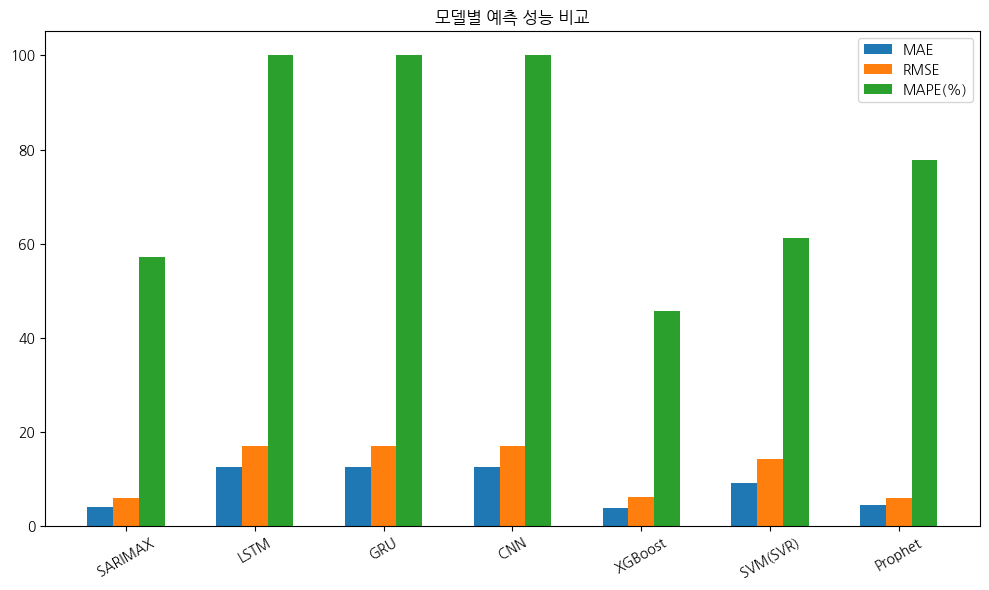

In [25]:
########################################
# 12. 결과 비교 (MAE, RMSE, MAPE)
########################################
results_df = pd.DataFrame([
    sarimax_result, lstm_result, gru_result, cnn_result,
    xgb_result, svr_result, prophet_result
])
print("\n=== 모델별 성능 지표 비교 ===")
display(results_df)

# MAPE 컬럼 이름 변경 (MAPE -> MAPE(%))
results_df.rename(columns={'MAPE': 'MAPE(%)'}, inplace=True)
results_df['MAPE(%)'] = results_df['MAPE(%)'] * 100 # MAPE를 percentage로 변환

# 시각화
plt.figure(figsize=(10,6))
bar_x = np.arange(len(results_df))
plt.bar(bar_x - 0.2, results_df['MAE'], 0.2, label='MAE')
plt.bar(bar_x,         results_df['RMSE'], 0.2, label='RMSE')
plt.bar(bar_x + 0.2,   results_df['MAPE(%)'], 0.2, label='MAPE(%)') # MAPE(%) label로 변경
plt.xticks(bar_x, results_df['model'], rotation=30)
plt.title("모델별 예측 성능 비교")
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
########################################
# 13. 마무리
########################################
print("\n작업 완료! 각 모델의 성능 지표가 results_df에 정리되었습니다.")
gc.collect()


작업 완료! 각 모델의 성능 지표가 results_df에 정리되었습니다.


50240